## Introduction

Classical SIR/SIRD models treat “infection” as a single compartment and ignore important stages such as incubation, severe illness, and temporary immunity. That makes them mathematically convenient, but biologically imprecise. Incubation delays transmission, bedridden patients have fewer contacts, and recovery often confers short-term immunity rather than permanent protection. In this project, the SIRD framework model is extended to a multi-stage model that tracks individuals through six health states: Healthy (H), Incubating (I), Contagious (C), Bed-ridden (B), Immune/Recovered (M), and Dead (D). At the population level, these states can be described by a system of coupled differential equations with parameters controlling infection, progression, recovery, and death rates. To capture individual variability and contact structure, our group implements these dynamics as an agent-based simulation on a contact network. Each person is a finite state machine (FSM) that moves between H, I, C, B, M, and D according to probabilistic rules calibrated to match target incubation times, contagious periods, and case fatality rates. Together, the compartmental model and network-based FSM provide a flexible tool for exploring how disease severity, contact patterns, and bed-rest policies shape outbreak trajectories.

## Compartmental Model

At the population level, we model the time evolution of the six health states with the following system of ODEs:


Healthy (H):
$ \frac{dH}{dt} = aM - bHC $

Incubating (I):
$ \frac{dI}{dt} = bHC - cI $

Contagious (C):
$ \frac{dC}{dt} = cI - (d+e+f)C $

Bed-ridden (B):
$ \frac{dB}{dt} = dC - (g+h)B $

Immune (M):
$ \frac{dM}{dt} = eC + hB - aM $

Dead (D):
$ \frac{dD}{dt} = fC + gB $




Here, parameters $a–h$ represent effective rates of loss of immunity, infection, incubation, progression to bed-rest, recovery, and death from either the Contagious or Bed-ridden states. These equations define the flow between compartments, approximating flow at the individual level.


## Agent Based Representation

We approximate the spread of disease with an agent-based model. Each individual is a SimIndividual object with a main health state (H/I/C/B/M/D), time-in-state, a disease severity “progress” score, and a health modifier that adjusts susceptibility and fatality risk. SimIndividuals can be assigned undirected, weighted connections to others, which allow for the disease to spread throughout the community: each connection is either strong (and often two-way) or weak (casual), and are all assigned by a managing Simulator class.

## Disease Progression and Transmission

Time is divided into days and “sub-days.” At each sub-day:

- Within-host progression:
Incubating individuals transition to Contagious after a random incubation duration drawn from PARAM_DISEASE_INCUBATION_MIN–MAX. Contagious and Bed-ridden individuals stochastically get better or worse based on PARAM_DISEASE_PROGRESS_UP and DOWN. A severity-dependent death probability is computed from baseline and maximum fatality parameters and the individual’s health. Recovery leads to a temporary Immune/Recovered state, then a return to Healthy after a fixed immunity window.

- Transmission:
Contagious (and at lower rates, Bed-ridden) individuals attempt to infect a subset of their strong and weak contacts each sub-day, with probabilities scaled by PARAM_DISEASE_SPREAD and connection type. Successful exposures move Healthy contacts into the Incubating state. Additional “spontaneous” exposures model infections from outside the explicit network.

## Output

The simulator runs for a fixed number of days and records the number of individuals in each state (H, I, C, B, M, D) at every sub-day. The time series will be used to generate epidemic curves, predicted using the ODE model. The curves can then be compared to known data.

## Implementation 
The Python 3 code responsible for managing and executing the epidemiology simulation is divided into several parts.
### Setup

In [21]:
# Imports and defaults
import random
import numpy as np
import networkx as nx
import json
import os
import plotly.express as px
import plotly.graph_objects as go
import panel

panel.extension('mathjax')

In [22]:
"""This is used to represent an individual that is susceptible to infection."""
PRESET_STATE_HEALTHY = 0

"""This is used to represent an individual that is infected and incubating, but
is not showing symptoms, and which is not capable of transmission yet."""
PRESET_STATE_INCUBATE = 1

"""This is used to represent an individual that is currently infected and symptomatic,
and capable of infecting Healthy individuals."""
PRESET_STATE_CONTAGIOUS = 2

"""This is used to represent an individual that is currently infected and symptomatic,
but is much less likely to expose others to infection by being confined to bedrest.
Also improves the patient's chances of survival slightly."""
PRESET_STATE_BEDRIDDEN = 3

"""This is used to represent an individual that was infected, but has recovered.
This will give the individual one week of guaranteed infection immunity."""
PRESET_STATE_RECOVERED = 4

"""This is used to represent an individual that was infected and succumbed to the
disease in question."""
PRESET_STATE_DECEASED = 5

## System Configurations

### Disease Behavior Parameters

In [23]:
# Disease Parameters

"""This modifier controls the likelihood of a Contagious individual exposing
and infecting a Healthy individual. It is the chance, before any individual
resistance or connection modifiers, of an infection occurring. Values are
expected to be in the range [0.2, 0.76]."""
CONFIG_DISEASE_SPREAD = panel.widgets.FloatSlider(name="Disease Spread",\
                                                  start=0.2,end=0.76,\
                                                  step=0.02,value=0.28)

"""This modifier controls the minimum number of days that the disease will
Incubate in an infected individual. Values are expected to be in the range
[1, 10]."""
CONFIG_DISEASE_INCUBATION_MIN = panel.widgets.IntSlider(name="Minimum Incubation Period (days)",\
                                                  start=1,end=10,value=3)

"""This modifier controls the maximum number of days that the disease can
Incubate in an infected individual. Values are expected to be in the range
[2, 14]."""
CONFIG_DISEASE_INCUBATION_MAX = panel.widgets.IntSlider(name="Maximum Incubation Period (days)",\
                                                  start=2,end=14,value=10)

"""This modifier controls the target number of days that the disease will be
Contagious in an infected individual. Values are expected to be in the range
[3, 28]."""
CONFIG_DISEASE_CONTAGIOUS_TARGET = panel.widgets.IntSlider(name="Average Disease Duration (days)",\
                                                  start=3,end=28,value=10)

"""This modifier controls the maximum 'progress' of the disease in an individual.
Every step of progress will slightly reduce the chance of progressing into the next,
but will also increase the chance of fatality. Every step of progress will also
slightly increase non-bedridden chances of spreading the disease. Values are
expected to be in the range [2, 20]."""
CONFIG_DISEASE_PROGRESS_MAX = panel.widgets.IntSlider(name="Max Disease Progress",\
                                                  start=2,end=20,value=12)

"""This modifier adjusts the risk of a Contagious case of the disease getting
worse for the patient. Values are expected to be in the range [0.01, 0.75]."""
CONFIG_DISEASE_PROGRESS_UP = panel.widgets.FloatSlider(name="Disease Worsening Propensity",\
                                                  start=0.01,end=0.75,value=0.3,step=0.01)

"""This modifier adjusts the chance of a Contagious case of the disease getting
better for the patient. Values are expected to be in the range [0.01, 0.75]."""
CONFIG_DISEASE_PROGRESS_DOWN = panel.widgets.FloatSlider(name="Disease Improvement Propensity",\
                                                  start=0.01,end=0.75,value=0.15,step=0.01)

"""This modifier controls the base risk of mortality associated with the disease.
Values are expected to be in the range [0, 0.1] for the baseline."""
CONFIG_DISEASE_FATALITY_BASE = panel.widgets.FloatSlider(name="Disease Base Fatality",\
                                                  start=0.0,end=0.1,value=0.01,step=0.001)

"""This modifier controls the maximum risk of mortality associated with a worst
severity case of the disease. Values are expected to be in the range [0.01, 0.5]."""
CONFIG_DISEASE_FATALITY_LIMIT = panel.widgets.FloatSlider(name="Disease Max Fatality",\
                                                  start=0.01,end=0.5,value=0.07,step=0.01)

"""This modifier controls how much the BEDRIDDEN state (medical bedrest) will
reduce the likelihood of a patient dying. Values are expected to be in the range
[0.01, 0.5]."""
CONFIG_DISEASE_BEDREST_EFFECT = panel.widgets.FloatSlider(name="Bedridden Improvement Factor",\
                                                  start=0.01,end=0.5,value=0.2,step=0.01)

# interactive display
CFGA = panel.Row(CONFIG_DISEASE_SPREAD, CONFIG_DISEASE_INCUBATION_MIN, \
          CONFIG_DISEASE_INCUBATION_MAX, CONFIG_DISEASE_CONTAGIOUS_TARGET)
CFGB = panel.Row(CONFIG_DISEASE_PROGRESS_MAX, CONFIG_DISEASE_PROGRESS_UP, \
          CONFIG_DISEASE_PROGRESS_DOWN, CONFIG_DISEASE_BEDREST_EFFECT)
CFGC = panel.Row(CONFIG_DISEASE_FATALITY_BASE, CONFIG_DISEASE_FATALITY_LIMIT)
panel.Column(CFGA, CFGB, CFGC)

Column
    [0] Row
        [0] FloatSlider(end=0.76, name='Disease Spread', start=0.2, step=0.02, value=0.28)
        [1] IntSlider(end=10, name='Minimum Incubation P..., start=1, value=3)
        [2] IntSlider(end=14, name='Maximum Incubation P..., start=2, value=10)
        [3] IntSlider(end=28, name='Average Disease D..., start=3, value=10)
    [1] Row
        [0] IntSlider(end=20, name='Max Disease Progress', start=2, value=12)
        [1] FloatSlider(end=0.75, name='Disease Worsening P..., start=0.01, step=0.01, value=0.3)
        [2] FloatSlider(end=0.75, name='Disease Improvement P..., start=0.01, step=0.01, value=0.15)
        [3] FloatSlider(end=0.5, name='Bedridden Improvement F..., start=0.01, step=0.01, value=0.2)
    [2] Row
        [0] FloatSlider(end=0.1, name='Disease Base Fatality', step=0.001, value=0.01)
        [1] FloatSlider(end=0.5, name='Disease Max Fatality', start=0.01, step=0.01, value=0.07)

### Population Setup Parameters

In [24]:
"""This parameter controls the total number of individuals in the population
being simulated. Values are expected to be in the range [10, 100000]."""
CONFIG_POPULATION_START = panel.widgets.EditableIntSlider(name="Starting Population",\
                                                  start=10,end=100000,value=400,step=10)

"""This parameter controls the maximum number of individuals in the population
that can be placed into the bedridden state. The individuals selected for these
'beds' will be done based on their priority for treatment, which is calculated
as (Disease Progress) * (2 - Individual Health Modifier). Values are expected
to be in the range [0, 5000]."""
CONFIG_POPULATION_MED_BEDS = panel.widgets.EditableIntSlider(name="Population Medical Beds",\
                                                  start=0,value=10,end=5000,step=1)

# The following variables pertain to "connections," which represents the 
# avenues for infection that this disease possesses.

"""This modifier controls the number of 'strong' connections that every
individual in the population is expected to have to other individuals. Values
are expected to be in the range [0, 12]."""
CONFIG_POPULATION_STRONGCOUNT = panel.widgets.IntSlider(name="Strong Connections per Individual",\
                                                  start=0,end=12,value=3)

"""This modifier controls the number of 'weak' connections that every
individual in the population is expected to have to other individuals. Values
are expected to be in the range [2, 24]."""
CONFIG_POPULATION_WEAKCOUNT = panel.widgets.IntSlider(name="Weak Connections per Individual",\
                                                  start=2,end=24,value=5)

"""This modifier controls the average 'health' of individuals in the population.
The individual health modifier adjusts risk of infection and fatality slightly.
Values are expected to be in the range [0.2, 0.8]."""
CONFIG_POPULATION_AVGHEALTH = panel.widgets.FloatSlider(name="Population Average Health Factor",\
                                                  start=0.2,end=0.8,value=0.4,step=0.01)

"""This modifier controls the variation in the health modifiers of individuals in
the population. Values are expected to be in the range [0.05, 0.375], and the final
health modifier for any given individual will be capped to the range [0.1, 0.9]."""
CONFIG_POPULATION_VARHEALTH = panel.widgets.FloatSlider(name="Population Health Factor Variability",\
                                                  start=0.05,end=0.375,value=0.15,step=0.01)

"""This modifier defines the number of individuals that are sick at the first 
timestep. Values are exepcted to be in the range [1, 30]."""
CONFIG_POPULATION_INITIAL_EXPOSURES = panel.widgets.IntSlider(name="Starting Infections",\
                                                  start=1,end=30,value=1)

"""This modifier controls the number of spontaneous exposures to attempt every day.
The likelihood of a random exposure causing infection is dependent on the proportion
of the population already infected, and on the health of the individual picked.
Values are expected to be in the range [1, 10]."""
CONFIG_POPULATION_BONUS_EXPOSURES = panel.widgets.IntSlider(name="Daily Weak Bonus Exposures",\
                                                  start=1,end=10,value=2)

CFGD = panel.Row(CONFIG_POPULATION_START, CONFIG_POPULATION_MED_BEDS, \
          CONFIG_POPULATION_STRONGCOUNT, CONFIG_POPULATION_WEAKCOUNT)
CFGE = panel.Row(CONFIG_POPULATION_AVGHEALTH, CONFIG_POPULATION_VARHEALTH, \
          CONFIG_POPULATION_INITIAL_EXPOSURES, CONFIG_POPULATION_BONUS_EXPOSURES)
panel.Column(CFGD, CFGE)

Column
    [0] Row
        [0] EditableIntSlider(end=100000, name='Starting Population', start=10, step=10, value=400, width=300)
        [1] EditableIntSlider(end=5000, name='Population Medical Beds', value=10, width=300)
        [2] IntSlider(end=12, name='Strong Connections p..., value=3)
        [3] IntSlider(end=24, name='Weak Connections p..., start=2, value=5)
    [1] Row
        [0] FloatSlider(end=0.8, name='Population Average H..., start=0.2, step=0.01, value=0.4)
        [1] FloatSlider(end=0.375, name='Population Health F..., start=0.05, step=0.01, value=0.15)
        [2] IntSlider(end=30, name='Starting Infections', start=1, value=1)
        [3] IntSlider(end=10, name='Daily Weak Bonus E..., start=1, value=2)

### Simulation Setup Parameters

In [25]:
"""This modifier controls the duration of the simulation, generally. Values are
expected to be in the range [10, 500]."""
CONFIG_SIMULATION_DAYS = panel.widgets.EditableIntSlider(name="Days to Simulate",\
                                                  start=10,end=500,value=40)
"""This modifier controls the number of subdivisions (for disease progress and
infection chances) to perform during every simulation day. Values are expected
to be in the range [2, 6]."""
CONFIG_SIMULATION_SUBDAYS = panel.widgets.IntSlider(name="Simulation Steps per Day",\
                                                  start=2,end=6,value=3)

panel.Row(CONFIG_SIMULATION_DAYS, CONFIG_SIMULATION_SUBDAYS)

Row
    [0] EditableIntSlider(end=500, name='Days to Simulate', start=10, value=40, width=300)
    [1] IntSlider(end=6, name='Simulation Steps p..., start=2, value=3)

## Simulation Type Definitions

In [26]:
"""Core Individual class. This is a single node within the undirected graph
structure that represents the simulated population. It tracks its own disease
state, strong and weak connections, and a health multiplier."""
class SimIndividual:
    def __init__(self, health: float = 0.0):
        """Construct a new Simulation Individual. If 'health' is set to 0.0, it
        will be automatically generated based on the population parameters."""
        
        self.state = {'main':PRESET_STATE_HEALTHY, 'subdays_active':0, 'progress':0, 
                      'update_subday_cnt':0, 'update_propensities':None}
        # 'subdays_active' tracks the amount of time the individual is in a state
        # 'progress' tracks Disease progress, if relevant
        # 'update_subday_cnt' tracks the timepoint for the next progress or state update
        # 'update_propensities' stores the propensities for the next state change, if relevant
        self.connect_strong = [None] * PARAM_POPULATION_STRONGCOUNT
        self.connect_strong_cnt = 0 # this is used to determine where we register
        self.connect_weak = [None] * PARAM_POPULATION_WEAKCOUNT
        self.connect_weak_cnt = 0
        if health == 0.0:
            self.health = min(0.9, max(0.1, random.gauss(PARAM_POPULATION_AVGHEALTH, PARAM_POPULATION_VARHEALTH)))
        else:
            self.health = health
            
    def assign_connection(self, who, strong: bool = False) -> bool:
        """Attempt to add a two-way connection between this Individual and the
        specified target Individual, of the specified strength level. Returns
        True if both Individuals had an open slot for the connection and one
        was successfully established, False otherwise."""
        if strong:
            selfallowed = self.connect_strong_cnt < PARAM_POPULATION_STRONGCOUNT
            themallowed = who.connect_strong_cnt < PARAM_POPULATION_STRONGCOUNT
            if selfallowed and themallowed:
                self.connect_strong[self.connect_strong_cnt] = who
                who.connect_strong[who.connect_strong_cnt] = self
                self.connect_strong_cnt += 1
                who.connect_strong_cnt += 1
                return True
            else:
                return False
        else:
            selfallowed = self.connect_weak_cnt < PARAM_POPULATION_WEAKCOUNT
            themallowed = who.connect_weak_cnt < PARAM_POPULATION_WEAKCOUNT
            if selfallowed and themallowed:
                self.connect_weak[self.connect_weak_cnt] = who
                who.connect_weak[who.connect_weak_cnt] = self
                self.connect_weak_cnt += 1
                who.connect_weak_cnt += 1
                return True
            else:
                return False

    def change_core_state(self, new_state: int) -> bool:
        """Attempt to change the current simulation state of this Individual to
        the specified integer, representing one of the PRESET_STATE entries.
        Returns True if the state was modified, False otherwise."""
        if self.state['main'] == new_state:
            return False
        else:
            self.state['main'] = new_state
            self.state['last_subdays'] = self.state['subdays_active']
            self.state['subdays_active'] = 0
            # perform "first change" logic for disease states
            if new_state == PRESET_STATE_INCUBATE:
                targetnum = random.randint(PARAM_SIMULATION_SUBDAYS * PARAM_DISEASE_INCUBATION_MIN,\
                                           PARAM_SIMULATION_SUBDAYS * PARAM_DISEASE_INCUBATION_MAX)
                self.state['update_subday_cnt'] = targetnum
            elif new_state == PRESET_STATE_CONTAGIOUS:
                self.state['update_propensities'] = self.disease_substate_nextgoal()
            elif new_state == PRESET_STATE_RECOVERED:
                self.state['update_subday_cnt'] = PARAM_SIMULATION_SUBDAYS * 7
            return True

    def disease_substate_nextgoal(self) -> tuple:
        """Determines the number of subdays until the next expected disease update,
        and assigns that to this Individual's state. Returns a tuple, containing
        the propensities for their condition worsening versus improving."""
        
        subday_fraction = self.state['subdays_active'] / (PARAM_DISEASE_CONTAGIOUS_TARGET * PARAM_SIMULATION_SUBDAYS)
        progress = self.state['progress']
        if progress:
            prop_up = PARAM_DISEASE_PROGRESS_UP * (1 + 0.2 * (PARAM_DISEASE_PROGRESS_MAX - progress)) \
                    * (1 - 0.2 * self.health) * random.uniform(0.9, 1.1) / (1 + 3 * subday_fraction)
            prop_dn = PARAM_DISEASE_PROGRESS_DOWN * (1 + 2 * subday_fraction) * (1 + 0.1 * self.health) \
                    * (0.375 + 0.5 * progress / PARAM_DISEASE_PROGRESS_MAX) * random.uniform(0.9, 1.1)
            # Apply an additional adjustment to disease recovery based on medical bedrest
            if self.state['main'] == PRESET_STATE_BEDRIDDEN:
                prop_up *= (1.0 - 0.5 * PARAM_DISEASE_BEDREST_EFFECT)
                prop_dn *= (1.0 + 0.1 * PARAM_DISEASE_BEDREST_EFFECT)
            target = round(PARAM_SIMULATION_SUBDAYS * random.expovariate(1.0 / (prop_up + prop_dn)))
            self.state['update_subday_cnt'] = target
            return (prop_up, prop_dn)
        else:
            prop_up = PARAM_DISEASE_PROGRESS_UP * (1 - 0.1 * self.health) * random.uniform(0.9, 1.1)
            target = round(PARAM_SIMULATION_SUBDAYS * random.expovariate(1.0 / prop_up))
            self.state['update_subday_cnt'] = target
            return (prop_up, 0.0)

    def state_subday_simulate(self):
        """Perform one sub-day of simulation for this Individual's state."""
        self.state['subdays_active'] += 1
        statenum = self.state['main']
        if statenum and self.state['subdays_active'] >= self.state['update_subday_cnt']:
            if statenum == PRESET_STATE_INCUBATE:
                # Disease progresses from Incubating to Contagious
                self.change_core_state(PRESET_STATE_CONTAGIOUS)
            elif statenum == PRESET_STATE_CONTAGIOUS:
                worsens = random.choices([True, False], self.state['update_propensities'])[0]
                if worsens:
                    self.state['progress'] += 1
                    if self.state['progress'] >= PARAM_DISEASE_PROGRESS_MAX:
                        self.state['progress'] = PARAM_DISEASE_PROGRESS_MAX
                else:
                    self.state['progress'] -= 1
                    if self.state['progress'] <= 0:
                        self.change_core_state(PRESET_STATE_RECOVERED)
                self.state['update_propensities'] = self.disease_substate_nextgoal()
                deathrisk = PARAM_DISEASE_FATALITY_BASE + ((PARAM_DISEASE_FATALITY_LIMIT - PARAM_DISEASE_FATALITY_BASE) \
                            * (self.state['progress'] / PARAM_DISEASE_PROGRESS_MAX))
                deathrisk *= (1.0 - 0.25 * self.health) / (1 + PARAM_SIMULATION_SUBDAYS) # fatality_base is in daily terms

                if random.uniform(0.0, 1.0) < deathrisk:
                    self.change_core_state(PRESET_STATE_DECEASED)
                    return
            elif statenum == PRESET_STATE_BEDRIDDEN:
                worsens = random.choices([True, False], self.state['update_propensities'])[0]
                if worsens:
                    self.state['progress'] += 1
                    if self.state['progress'] >= PARAM_DISEASE_PROGRESS_MAX:
                        self.state['progress'] = PARAM_DISEASE_PROGRESS_MAX
                else:
                    self.state['progress'] -= 1
                    if self.state['progress'] <= 0:
                        self.change_core_state(PRESET_STATE_RECOVERED)
                self.state['update_propensities'] = self.disease_substate_nextgoal()
                deathrisk = PARAM_DISEASE_FATALITY_BASE + ((PARAM_DISEASE_FATALITY_LIMIT - PARAM_DISEASE_FATALITY_BASE) \
                            * (self.state['progress'] / PARAM_DISEASE_PROGRESS_MAX))
                deathrisk *= (1.0 - 0.3 * self.health) / (1 + PARAM_SIMULATION_SUBDAYS) # fatality_base is in daily terms
                # Bedridden patients get a bonus to reducing death risk, alongside reduced exposure risks
                deathrisk *= (1.0 - PARAM_DISEASE_BEDREST_EFFECT)

                if random.uniform(0.0, 1.0) < deathrisk:
                    self.change_core_state(PRESET_STATE_DECEASED)
                    return

    def infection_progress_simulate(self):
        """Simulate how this individual can expose others to the disease, if they
        are infected. No effect on HEALTHY, DECEASED, INCUBATING or RECOVERED
        SimIndividuals. Intended to be simulated on the subday level."""
        connections = PARAM_POPULATION_STRONGCOUNT + PARAM_POPULATION_WEAKCOUNT
        statenum = self.state['main']
        step_spreadval = PARAM_DISEASE_SPREAD * (1.0 - 0.125 * self.health) \
                       * random.triangular(0.75, 1.25, 1.0)
        if statenum == PRESET_STATE_CONTAGIOUS:
            connection_props = []
            for i in range(PARAM_POPULATION_STRONGCOUNT):
                connection_props.append(random.betavariate(0.75, 2.7) * \
                                        step_spreadval)
            for i in range(PARAM_POPULATION_WEAKCOUNT):
                connection_props.append(random.betavariate(0.625, 2.75) * \
                                        step_spreadval)
            expected_exposures = int(sum(connection_props) * connections)
            if expected_exposures <= 0:
                expected_exposures = 1
            to_try = random.choices(range(connections),k=expected_exposures)
            for who in to_try:
                chance = random.uniform(0.001, 0.01) + connection_props[who]
                # 2% of ignoring an exposure
                if random.random() < chance and random.random() > 0.02:
                    # exposure occurs!
                    target = None
                    if who < PARAM_POPULATION_STRONGCOUNT:
                        target = self.connect_strong[who]
                    else:
                        idx = who - PARAM_POPULATION_STRONGCOUNT
                        target = self.connect_weak[idx]
                    if target == None:
                        return
                    elif target.state['main'] == 0:
                        target.change_core_state(PRESET_STATE_INCUBATE)
        elif statenum == PRESET_STATE_BEDRIDDEN:
            connection_props = []
            for i in range(PARAM_POPULATION_STRONGCOUNT):
                connection_props.append(random.betavariate(0.625, 2.85) * \
                                        step_spreadval)
            for i in range(PARAM_POPULATION_WEAKCOUNT):
                connection_props.append(random.betavariate(0.5, 2.9) * \
                                        step_spreadval)
            expected_exposures = int(sum(connection_props) * connections)
            if expected_exposures <= 0:
                expected_exposures = 1
            to_try = random.choices(range(connections),k=expected_exposures)
            for who in to_try:
                chance = random.uniform(0.0, 0.005) + connection_props[who]
                # 8% chance of ignoring an exposure
                if random.random() < chance and random.random() > 0.08:
                    # exposure occurs!
                    target = None
                    if who < PARAM_POPULATION_STRONGCOUNT:
                        target = self.connect_strong[who]
                    else:
                        target = self.connect_weak[who - PARAM_POPULATION_STRONGCOUNT]
                    if target == None:
                        return
                    elif target.state['main'] == 0:
                        target.change_core_state(PRESET_STATE_INCUBATE)
        else:
            return

In [27]:
class Simulator:
    def __init__(self, population_size):
        """Creates a simulator object, which will generate individuals, tell 
        them to update their states, and collect data on the states of 
        individuals."""
        self.population_size = population_size
        self.individuals = [None] * population_size
        self.individual_counts_in_each_state = {
            PRESET_STATE_HEALTHY: 0,
            PRESET_STATE_INCUBATE: 0,
            PRESET_STATE_CONTAGIOUS: 0,
            PRESET_STATE_BEDRIDDEN: 0,
            PRESET_STATE_RECOVERED: 0,
            PRESET_STATE_DECEASED: 0
        }

        # Define some other parameters
        self.simulation_iteration_length = PARAM_SIMULATION_DAYS * \
            PARAM_SIMULATION_SUBDAYS

        # Create a dictionary to store simulation data for reference later; 
        # These values are on a per-subday basis. Taking their sum gives the 
        # total values across the current iteration.
        self.per_subday_simulation_data = {
            "recoveries": np.zeros(self.simulation_iteration_length),
            "deaths": np.zeros(self.simulation_iteration_length),
            PRESET_STATE_HEALTHY: np.zeros(self.simulation_iteration_length),
            PRESET_STATE_INCUBATE: np.zeros(self.simulation_iteration_length),
            PRESET_STATE_CONTAGIOUS: np.zeros(self.simulation_iteration_length),
            PRESET_STATE_BEDRIDDEN: np.zeros(self.simulation_iteration_length),
            PRESET_STATE_RECOVERED: np.zeros(self.simulation_iteration_length),
            PRESET_STATE_DECEASED: np.zeros(self.simulation_iteration_length)
        }

        # Create a list to store each iteration of the simulation
        self.per_iteration_simulation_data = [None]
    

    # Callable functions
    def perform_single_simulation(self, autoinfect: bool = True):
        """Perform the simulation outlined in the parameters of this program 
        and this class."""
        # Start by resetting the individuals list and initializing the
        # individuals' connections

        # Sanity check before calling the initializer
        if self.individuals[0] == None:
            self.initialize_individuals()

        if autoinfect:
            # --Infect initial individuals in the population--
            # Randomly select individuals to infect
            individuals_to_infect = np.random.choice(self.individuals,\
                                       PARAM_POPULATION_INITIAL_EXPOSURES,\
                                       replace=False)
            # Loop over these individuals and infect them
            for individual in individuals_to_infect:
                individual.change_core_state(PRESET_STATE_INCUBATE)
        
        # Simulate each day
        for day_id in range(PARAM_SIMULATION_DAYS):
            # Simulate each subday
            for subday_id in range(PARAM_SIMULATION_SUBDAYS):
                # Get the absolute subday count
                absolute_subday = PARAM_SIMULATION_SUBDAYS * day_id + \
                                  subday_id

                treatment_targets = [] # stores the treatment priorities
                # Loop over all individuals and progress their illnesses
                for individual in self.individuals:
                    # Determine this individual's state
                    individual_state = individual.state['main']

                    # Log the counts of individuals in each state
                    self.per_subday_simulation_data[individual_state]\
                         [absolute_subday] += 1

                    # Record treatment priority
                    if individual_state == PRESET_STATE_CONTAGIOUS or\
                    individual_state == PRESET_STATE_BEDRIDDEN:
                        p = individual.state['progress'] 
                        p *= (2 - individual.health)
                        treatment_targets.append((p, individual))
                                           
                    # Illness progression
                    individual.state_subday_simulate()
                    # Individual-to-individual disease spread
                    individual.infection_progress_simulate()

            # --Process medical beds for Bedridden individuals--
            # This will ONLY process CONTAGIOUS or BEDRIDDEN persons.
            if PARAM_POPULATION_MED_BEDS > 0:
                treatment_targets = sorted(treatment_targets, key=lambda data:\
                                           data[0])
                if len(treatment_targets) < PARAM_POPULATION_MED_BEDS:
                    for i in treatment_targets:
                        # If we don't have a lot of people sick, only fill some
                        if i[0] * random.uniform(0.8, 1.2) > 3:
                            i[1].state['main'] = PRESET_STATE_BEDRIDDEN
                        else:
                            i[1].state['main'] = PRESET_STATE_CONTAGIOUS
                else:
                    for i in treatment_targets[0:PARAM_POPULATION_MED_BEDS]:
                        i[1].state['main'] = PRESET_STATE_BEDRIDDEN
                    for i in treatment_targets[PARAM_POPULATION_MED_BEDS:]:
                        i[1].state['main'] = PRESET_STATE_CONTAGIOUS
            
            # --Perform spontaneous transmission--
            # Select random individuals
            spontaneous_infections = np.random.choice(self.individuals,\
                                     PARAM_POPULATION_BONUS_EXPOSURES,\
                                     replace=True)
            # Loop over these individuals and attempt to infect them
            for individual in spontaneous_infections:
                # Only infect individuals that can be
                if individual.state['main'] == PRESET_STATE_HEALTHY:
                    # --Randomly infect based on disease parameters and the number
                    # of currently infected individuals--
                    # Get the percentage of individuals currently infected
                    infected_count = self.per_subday_simulation_data\
                                             [PRESET_STATE_CONTAGIOUS]\
                                             [(day_id+1) * PARAM_SIMULATION_SUBDAYS-1]
                    infected_fraction = infected_count / self.population_size

                    # If a random number is less than the disease spread parameter
                    # times this fraction, infect the individual
                    if random.random() < PARAM_DISEASE_SPREAD * infected_fraction:
                        individual.state['main'] = PRESET_STATE_INCUBATE

        return self.per_subday_simulation_data
    

    # Utility functions
    def initialize_individuals(self):
        """Fill the individuals array with SimIndividual objects and 
        connect each individual to a random assortment of others according
        to simulation parameters."""
        # Loop over each entry in the individuals array
        for i in range(self.population_size):
            # Create an individual and put it in this entry (overwrite 
            # previous individuals)
            self.individuals[i] = SimIndividual()
        
        # Now that all individuals are initialized, loop over all of them
        # once more to add strong and weak connections
        for i in range(self.population_size):
            # Get the data for the current individual
            this_individual = self.individuals[i]
            
            # Count how many strong connections have been successfully made
            # for this individual
            strong_connections_made = this_individual.connect_strong_cnt

            # Ensure that the simulation doesn't run too inefficiently or forever
            attempts = 0

            # Don't re-connect to nodes we're connected to
            existing = [i]

            # While not enough strong connections have been made for this 
            # individual, add more
            while strong_connections_made < PARAM_POPULATION_STRONGCOUNT \
                  and attempts < 11:
                # Count number of attempts
                attempts += 1
                
                # Grab another random individual
                random_individual_id = i
                # Ensure that the random individual is not this individual
                while random_individual_id in existing:
                    random_individual_id = \
                        random.randint(0,self.population_size-1)
                
                # Grab this individual's data from the population
                random_individual = self.individuals[random_individual_id]
                
                # If this connection was made successfully, increment the 
                # strong connections made counter
                if this_individual.assign_connection(random_individual,\
                                                     strong=True):
                    strong_connections_made += 1
                    existing.append(random_individual_id)
                

            # --Repeat above code but for weak connections--
            # Count how many weak connections have been successfully made
            # for this individual
            weak_connections_made = this_individual.connect_weak_cnt
            attempts = 0
            while weak_connections_made < PARAM_POPULATION_WEAKCOUNT - 2 \
                  and attempts < 11:
                # Count number of attempts
                attempts += 1
                
                # Grab another random individual
                random_individual_id = i
                # Ensure that the random individual is not this individual
                while random_individual_id in existing:
                    random_individual_id = \
                        random.randint(0,self.population_size-1)
                
                # Grab this individual's data from the population
                random_individual = self.individuals[random_individual_id]
                
                # If this connection was made successfully, increment the 
                # strong connections made counter
                if this_individual.assign_connection(random_individual,\
                                                     strong=False):
                    weak_connections_made += 1

        # Assign connections between nodes
        # Round 1 is to simply assign weak connections to neighboring nodes in
        # the storage array. This will create 2 weak connections for all nodes,
        # the minimum described in the documentation.
        for i in range(self.population_size):
            self.individuals[i].assign_connection(self.individuals[i-1], False)
            self.individuals[i].assign_connection(self.individuals[i-2], False)

# Simulation Execution

In [28]:
# Setup the global variables here.
PARAM_DISEASE_SPREAD = CONFIG_DISEASE_SPREAD.value
PARAM_DISEASE_INCUBATION_MIN = CONFIG_DISEASE_INCUBATION_MIN.value
PARAM_DISEASE_INCUBATION_MAX = CONFIG_DISEASE_INCUBATION_MAX.value
PARAM_DISEASE_CONTAGIOUS_TARGET = CONFIG_DISEASE_CONTAGIOUS_TARGET.value
PARAM_DISEASE_PROGRESS_MAX = CONFIG_DISEASE_PROGRESS_MAX.value
PARAM_DISEASE_PROGRESS_UP = CONFIG_DISEASE_PROGRESS_UP.value
PARAM_DISEASE_PROGRESS_DOWN = CONFIG_DISEASE_PROGRESS_DOWN.value
PARAM_DISEASE_FATALITY_BASE = CONFIG_DISEASE_FATALITY_BASE.value
PARAM_DISEASE_FATALITY_LIMIT = CONFIG_DISEASE_FATALITY_LIMIT.value
PARAM_DISEASE_BEDREST_EFFECT = CONFIG_DISEASE_BEDREST_EFFECT.value
# population parameters
PARAM_POPULATION_START = CONFIG_POPULATION_START.value
PARAM_POPULATION_MED_BEDS = CONFIG_POPULATION_MED_BEDS.value
PARAM_POPULATION_STRONGCOUNT = CONFIG_POPULATION_STRONGCOUNT.value
PARAM_POPULATION_WEAKCOUNT = CONFIG_POPULATION_WEAKCOUNT.value
PARAM_POPULATION_AVGHEALTH = CONFIG_POPULATION_AVGHEALTH.value
PARAM_POPULATION_VARHEALTH = CONFIG_POPULATION_VARHEALTH.value
PARAM_POPULATION_INITIAL_EXPOSURES = CONFIG_POPULATION_INITIAL_EXPOSURES.value
PARAM_POPULATION_BONUS_EXPOSURES = CONFIG_POPULATION_BONUS_EXPOSURES.value
# setup parameters
PARAM_SIMULATION_DAYS = CONFIG_SIMULATION_DAYS.value
PARAM_SIMULATION_SUBDAYS = CONFIG_SIMULATION_SUBDAYS.value

def update_simulation_parameters():
    PARAM_DISEASE_SPREAD = CONFIG_DISEASE_SPREAD.value
    PARAM_DISEASE_INCUBATION_MIN = CONFIG_DISEASE_INCUBATION_MIN.value
    PARAM_DISEASE_INCUBATION_MAX = CONFIG_DISEASE_INCUBATION_MAX.value
    PARAM_DISEASE_CONTAGIOUS_TARGET = CONFIG_DISEASE_CONTAGIOUS_TARGET.value
    PARAM_DISEASE_PROGRESS_MAX = CONFIG_DISEASE_PROGRESS_MAX.value
    PARAM_DISEASE_PROGRESS_UP = CONFIG_DISEASE_PROGRESS_UP.value
    PARAM_DISEASE_PROGRESS_DOWN = CONFIG_DISEASE_PROGRESS_DOWN.value
    PARAM_DISEASE_FATALITY_BASE = CONFIG_DISEASE_FATALITY_BASE.value
    PARAM_DISEASE_FATALITY_LIMIT = CONFIG_DISEASE_FATALITY_LIMIT.value
    PARAM_DISEASE_BEDREST_EFFECT = CONFIG_DISEASE_BEDREST_EFFECT.value
    # population parameters
    PARAM_POPULATION_START = CONFIG_POPULATION_START.value
    PARAM_POPULATION_MED_BEDS = CONFIG_POPULATION_MED_BEDS.value
    PARAM_POPULATION_STRONGCOUNT = CONFIG_POPULATION_STRONGCOUNT.value
    PARAM_POPULATION_WEAKCOUNT = CONFIG_POPULATION_WEAKCOUNT.value
    PARAM_POPULATION_AVGHEALTH = CONFIG_POPULATION_AVGHEALTH.value
    PARAM_POPULATION_VARHEALTH = CONFIG_POPULATION_VARHEALTH.value
    PARAM_POPULATION_INITIAL_EXPOSURES = CONFIG_POPULATION_INITIAL_EXPOSURES.value
    PARAM_POPULATION_BONUS_EXPOSURES = CONFIG_POPULATION_BONUS_EXPOSURES.value
    # setup parameters
    PARAM_SIMULATION_DAYS = CONFIG_SIMULATION_DAYS.value
    PARAM_SIMULATION_SUBDAYS = CONFIG_SIMULATION_SUBDAYS.value

# Global variable to store the most recent set of simulation results
MostRecentSimulation = {}
ButtonExecute = panel.widgets.Button(name='Simulate', button_type='primary')
IndicatorExecute = panel.widgets.LoadingSpinner(value=False, size=25, \
                                                bgcolor='dark',color='info')

def button_execute_simulation(event):
    """Executes the simulation in response to a button click. If the event
    is valid, this will load the current configuration parameters and then
    perform the simulation as requested, and will assign the output from the
    Simulator used for this round to MostRecentSimulation."""
    if not event:
        return
    IndicatorExecute.value = True
    ButtonExecute.button_style='outline'
    update_simulation_parameters()
    SimulatorManager = Simulator(PARAM_POPULATION_START)
    Output = SimulatorManager.perform_single_simulation()
    ButtonExecute.button_style='solid'
    MostRecentSimulation["Healthy"] = Output[PRESET_STATE_HEALTHY]
    MostRecentSimulation["Incubating"] = Output[PRESET_STATE_INCUBATE]
    MostRecentSimulation["Contagious"] = Output[PRESET_STATE_CONTAGIOUS]
    MostRecentSimulation["Bedridden"] = Output[PRESET_STATE_BEDRIDDEN]
    MostRecentSimulation["Recovered"] = Output[PRESET_STATE_RECOVERED]
    MostRecentSimulation["Deceased"] = Output[PRESET_STATE_DECEASED]
    IndicatorExecute.value = False
    return

panel.bind(button_execute_simulation, ButtonExecute, watch=True)
panel.Row(ButtonExecute, IndicatorExecute)

Row
    [0] Button(button_type='primary', name='Simulate')
    [1] LoadingSpinner(bgcolor='dark', color='info', size=25)

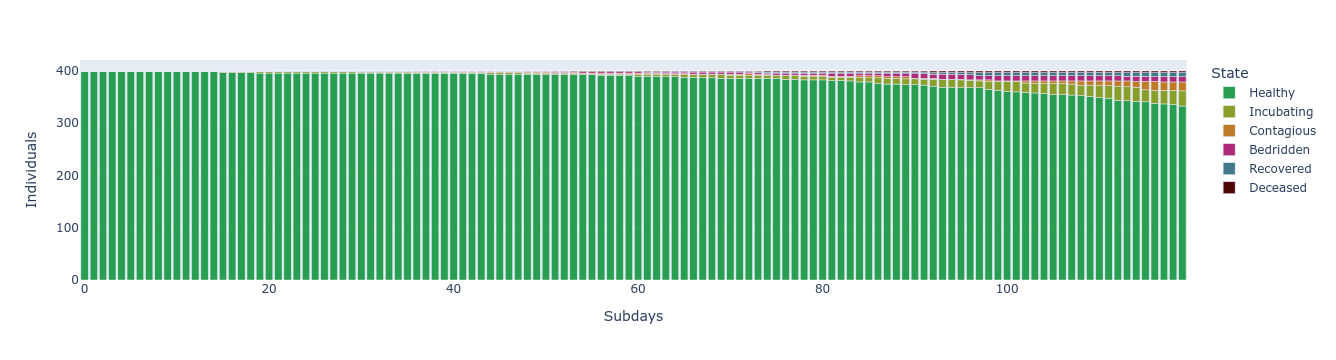

In [32]:
# This code renders the most recent simulation as an interactive chart.
fig_coloration = {
    "Healthy":"#289F50","Incubating":"#8A9F2A","Contagious":"#BF7A25",
    "Bedridden":"#B02A7A","Recovered":"#407A8A","Deceased":"#500707"
}
figure = px.bar(MostRecentSimulation, labels={
    "index":"Subdays", "value":"Individuals", "variable":"State"
}, color_discrete_map=fig_coloration)
figure.show()

## Results and Discussion

In [43]:
################################################################################
def save_simulation_data_to_json(simulation_data, data_path, file_name):
    """simulation_data: the output of Simulator.perform_single_simulation()

    data_path: a string designating the folder in which the file is generated. 
    Please use '\\' instead of '/' to ensure consistent formatting
    (eg. "data_out\\").
    
    file_name: the name of the file to be outputted. Please include the file
    extension (eg. "data.json")."""
    serializable_simulation_data = make_JSON_serializable(simulation_data)

    with open(data_path + file_name, "w") as data_file:
        json.dump(serializable_simulation_data, data_file)

    print("Find data at " + os.getcwd() + "\\" + data_path + file_name)

In [44]:
# Perform a simulation and save the file to 'data_out/data.json.'
save_simulation_data_to_json(MostRecentSimulation, "data_out\\", "data.json")

Find data at /home/code-meister/Documents/Genuinely_Personal/CSM/Biol301/notebooks/projectgit\data_out\data.json


## Visualizations

In [14]:
def build_population_graph(individuals):
    """Generates a networkX graph by creating a node for every 
    individual in the simulation, and creating edges for every weak
    and strong connection"""
    
    G = nx.Graph()

    # Map individuals to integer IDs
    id_map = {ind: idx for idx, ind in enumerate(individuals)}

    # Add a node for every person
    for idx in range(len(individuals)):
        G.add_node(idx)

    # Add all the edges
    for person in individuals:
        this_id = id_map[person]

        # Strong connections
        for neighbor in person.connect_strong[:person.connect_strong_cnt]:
            if neighbor is not None:
                neighbor_id = id_map[neighbor]
                if this_id != neighbor_id:  # prevent adding duplicate undirected edges
                    G.add_edge(this_id, neighbor_id, type="strong")

        # Weak connections
        for neighbor in person.connect_weak[:person.connect_weak_cnt]:
            if neighbor is not None:
                neighbor_id = id_map[neighbor]
                if this_id != neighbor_id:
                    G.add_edge(this_id, neighbor_id, type="weak", weight=0.1)

    return G

def plot_graph_plotly(G, pos):
    """Converts our networkX data to datatypes plotly can understand
    and generates our graph"""
    
    # Initialize edge traces
    strong_x, strong_y = [], []
    weak_x, weak_y = [], []

    # unpack our position data
    for u, v, data in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]

        if data["type"] == "strong":
            strong_x += [x0, x1, None]
            strong_y += [y0, y1, None]
        else:
            weak_x += [x0, x1, None]
            weak_y += [y0, y1, None]

    # TODO: some way to sort the nodes into visual clusters?
    # Since they're all assigned based on steps of 1 + STRONG CONNECTIONS,
    # we could just make "groups" of them in that way for easier visualization

    
    # Make our strong edge objects
    strong_edges = go.Scatter(
        x=strong_x, y=strong_y,
        mode="lines",
        line=dict(width=2, color="purple"),
        name="Strong connections"
    )

    # Make our weak edge objects
    weak_edges = go.Scatter(
        x=weak_x, y=weak_y,
        mode="lines",
        line=dict(width=1, color="teal"),
        name="Weak connections"
    )

    # Nodes/Individuals
    # unpack node position (we will be using networkX to generate this)
    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]

    # make our node objects
    nodes = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        marker=dict(
            size=8,
            color="darkblue"
        ),
        name="Individuals"
    )

    # settings for how the graph looks
    fig = go.Figure(data=[strong_edges, weak_edges, nodes])

    fig.update_layout(
        title="Connections Between Individuals",
        showlegend=True,
        hovermode='closest',
        width=900,
        height=700,
        plot_bgcolor="lightgray",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    fig.update_traces(marker=dict(size=12, 
                            line=dict(width=2, 
                            color='White')))
    fig.show()

<<<<<<< local


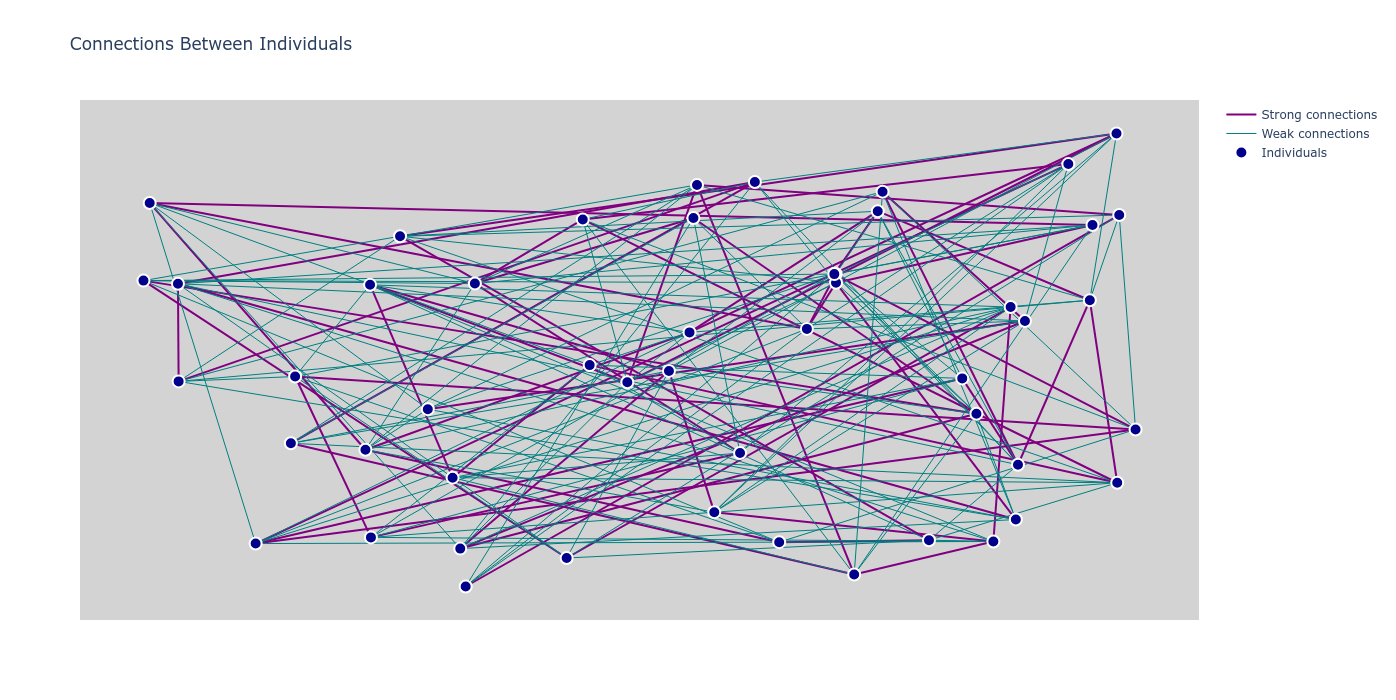

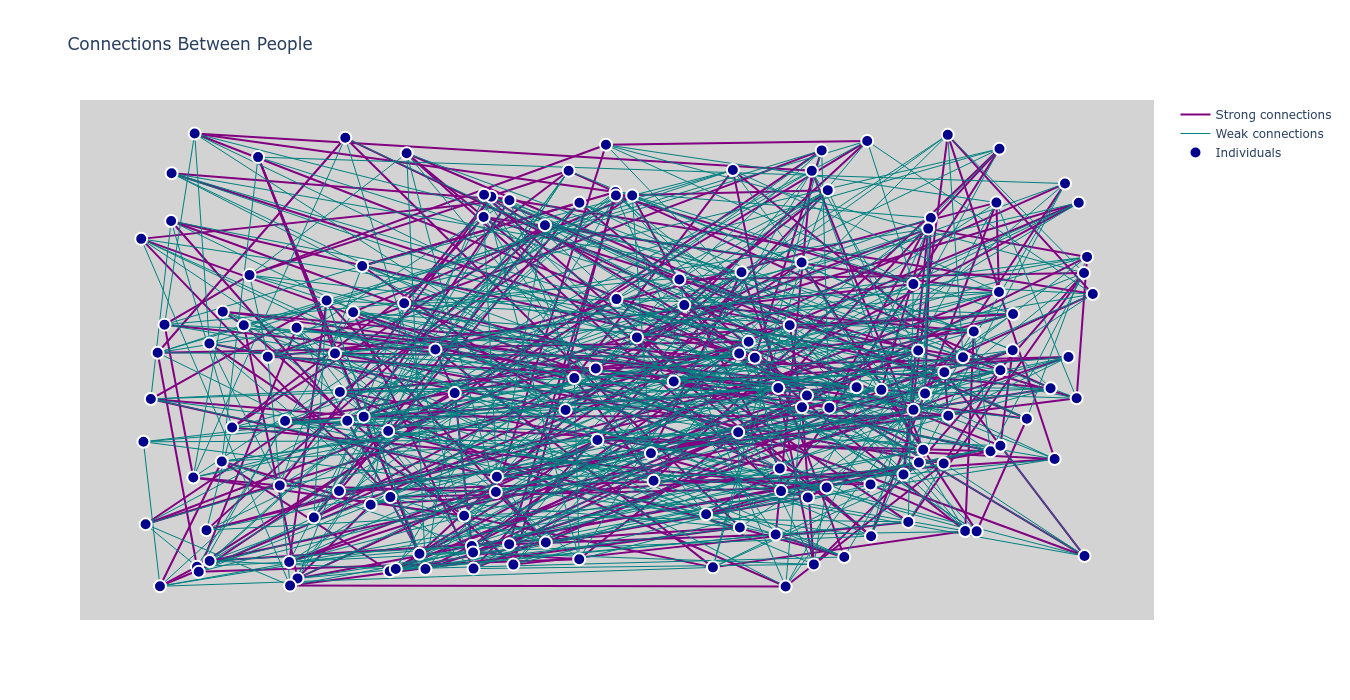

>>>>>>> remote


In [15]:
def compute_layout(G):
    """uses networkX's random layout to generate locations for our nodes"""
    #return nx.circular_layout(G,center=(0,0),dim=2)
    return nx.random_layout(G,center=(0,0),dim=2)

sim2 = Simulator(50)
sim2.initialize_individuals()

# Build the graph
G = build_population_graph(sim2.individuals)

# Compute layout
pos = compute_layout(G)

# Display
plot_graph_plotly(G, pos)

## References

https://pmc.ncbi.nlm.nih.gov/articles/PMC9212253/
